In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [7]:
data = pd.read_csv('../data/MXvideos_cc50_202101.csv')

In [8]:
data_limpia = data.drop_duplicates()
data_limpia = data_limpia.drop_duplicates(subset='video_id')

In [9]:
#Verificar datos faltantes
def imprimir_nulos(df):
    total = len(df)
    for col in df.columns:
        nulos = df[col].isnull().sum()
        if nulos > 0:
            porcentaje = round((nulos / total) * 100, 2)
            print(f"La columna '{col}' tiene {nulos} datos vacíos, representan un {porcentaje}% de los registros")

print("Reporte de valores nulos tras eliminar duplicados:\n")
imprimir_nulos(data_limpia)

Reporte de valores nulos tras eliminar duplicados:

La columna 'video_id' tiene 1 datos vacíos, representan un 0.0% de los registros
La columna 'trending_date' tiene 665 datos vacíos, representan un 1.94% de los registros
La columna 'title' tiene 701 datos vacíos, representan un 2.05% de los registros
La columna 'channel_title' tiene 710 datos vacíos, representan un 2.07% de los registros
La columna 'category_id' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'publish_time' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'tags' tiene 725 datos vacíos, representan un 2.12% de los registros
La columna 'views' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'likes' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'dislikes' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'comment_count' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'thumbn

In [10]:
#Eliminar datos críticos que representan una minoría del dataset
total = len(data_limpia)
columnas_criticas = [
    'video_id', 'trending_date', 'title', 'channel_title', 'category_id',
    'publish_time', 'tags', 'views', 'likes', 'dislikes'
]

for col in columnas_criticas:
    nulos = data_limpia[col].isnull().sum()
    porcentaje = nulos / total
    if porcentaje <= 0.10 and nulos > 0:
        print(f"Eliminando {nulos} registros con nulos en columna crítica: {col} ({round(porcentaje*100,2)}%)")
        data_limpia = data_limpia[data_limpia[col].notnull()]

print("\nValores nulos restantes después de limpieza final:")
imprimir_nulos(data_limpia)

Eliminando 1 registros con nulos en columna crítica: video_id (0.0%)
Eliminando 664 registros con nulos en columna crítica: trending_date (1.94%)
Eliminando 36 registros con nulos en columna crítica: title (0.11%)
Eliminando 9 registros con nulos en columna crítica: channel_title (0.03%)
Eliminando 28 registros con nulos en columna crítica: category_id (0.08%)

Valores nulos restantes después de limpieza final:
La columna 'description' tiene 3627 datos vacíos, representan un 10.82% de los registros


In [11]:
#Imputar una descripción simbólica a aquellos registros sin descripción
def rellenar_descripcion(df):
    if 'description' in df.columns:
        df['description'] = df['description'].fillna("Sin descripción")
    return df

data_limpia = rellenar_descripcion(data_limpia)
imprimir_nulos(data_limpia)

In [13]:
columnas = ['views', 'likes', 'dislikes', 'comment_count']

for col in columnas:
    Q1 = data_limpia[col].quantile(0.25)
    Q3 = data_limpia[col].quantile(0.75)
    minimo = data_limpia[col].min()
    maximo = data_limpia[col].max()
    print(f"{col} → Min: {minimo:.2f}, Q1: {Q1:.2f}, Q3: {Q3:.2f}, Max: {maximo:.2f}")

views → Min: 157.00, Q1: 13805.00, Q3: 137410.00, Max: 39349928.00
likes → Min: 0.00, Q1: 248.00, Q3: 4984.00, Max: 3880211.00
dislikes → Min: 0.00, Q1: 14.00, Q3: 171.00, Max: 483969.00
comment_count → Min: 0.00, Q1: 33.00, Q3: 632.00, Max: 692356.00


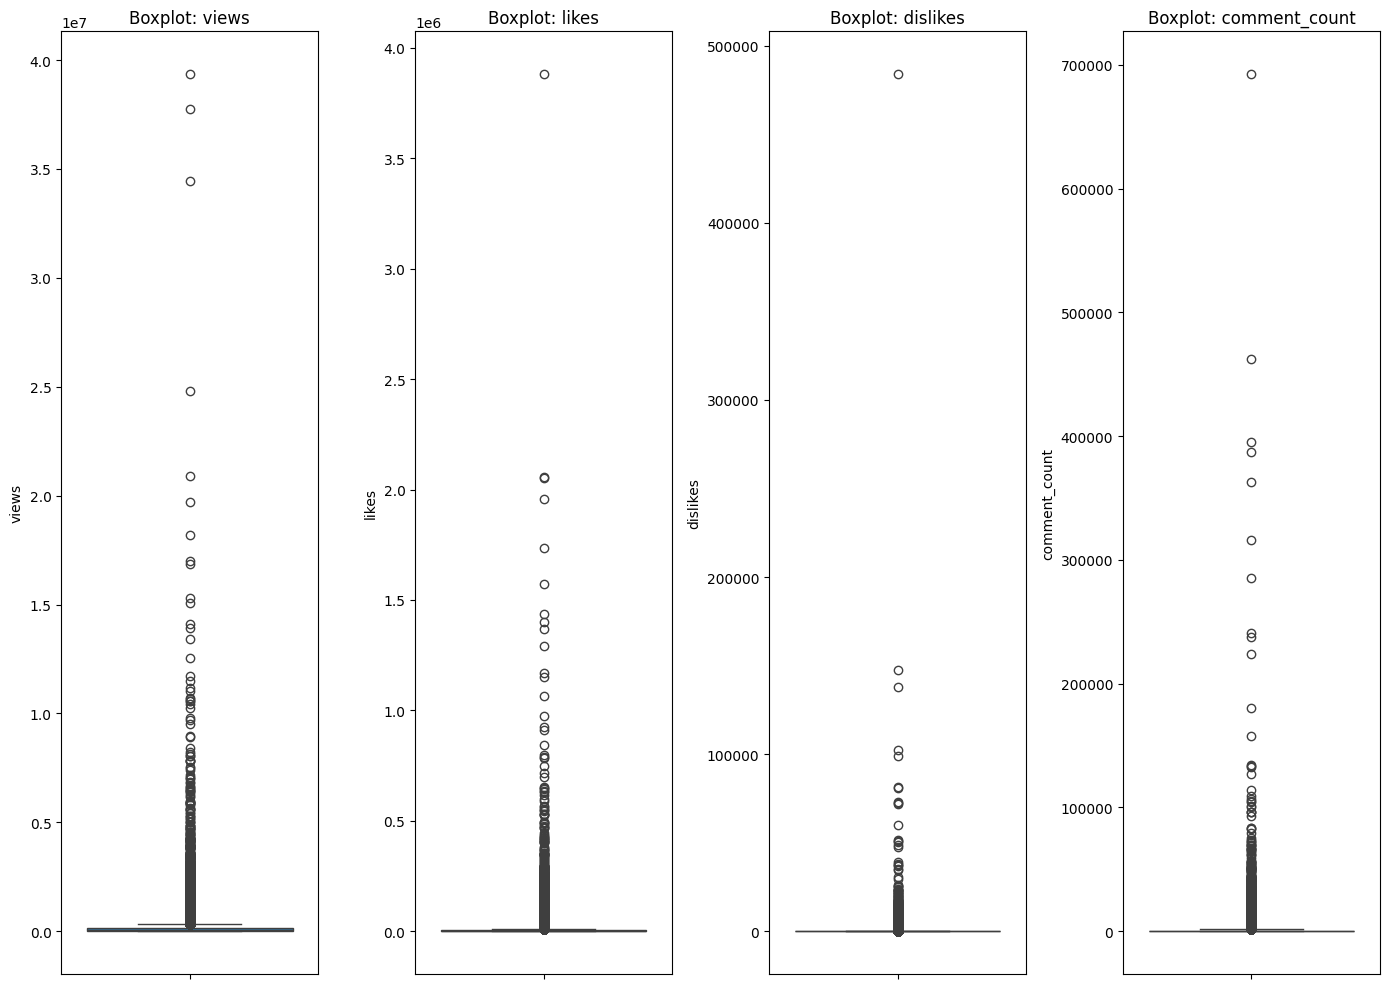

In [14]:
# Boxplots para identificar outliers en columnas numéricas
plt.figure(figsize=(14, 10))
for i, col in enumerate(['views', 'likes', 'dislikes', 'comment_count']):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=data_limpia[col])
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()

#📌 Winsorización
Se aplicó la winsorización al 1% y 99% para reducir la influencia de valores extremos sin eliminar registros. Esta técnica conserva la integridad del dataset y estabiliza medidas como la media y la varianza, especialmente en variables con datos altamente virales como views y likes.

#📌 Transformación logarítmica
Se utilizó la transformación logarítmica (log(x + 1)) para comprimir la escala de las variables numéricas y mejorar su interpretabilidad. Esto facilita comparaciones proporcionales, análisis de tendencias y modelos predictivos, al suavizar distribuciones sesgadas.

| Nº | Pregunta                                                                             | ¿Usar log? | Justificación                                                                      |
| -- | ------------------------------------------------------------------------------------ | ---------- | ---------------------------------------------------------------------------------- |
| 1  | ¿Qué categorías de videos son las de mayor tendencia?                                | ❌          | Puedes usar conteo de videos o views directos (sin log).                           |
| 2  | ¿Qué categorías de videos son los que más gustan? ¿Y las que menos gustan?           | ✅          | El log evita que unos pocos videos con millones de likes dominen el promedio.      |
| 3  | ¿Qué categorías tienen mejor ratio “Me gusta” / “No me gusta”?                       | ✅          | El uso de `log(likes+1)/log(dislikes+1)` estabiliza proporciones sesgadas.         |
| 4  | ¿Qué categorías tienen mejor ratio “Vistas” / “Comentarios”?                         | ✅          | El log ayuda a interpretar mejor la interacción media, evitando valores extremos.  |
| 5  | ¿Cómo ha cambiado el volumen de videos en tendencia a lo largo del tiempo?           | ❌          | Puedes usar conteo directo por fecha o categoría.                                  |
| 6  | ¿Qué Canales son tendencia más frecuentemente? ¿Y cuáles con menos frecuencia?       | ❌          | Aquí se usa frecuencia (conteo), no valores numéricos extremos.                    |
| 7  | ¿En qué Estados se presenta el mayor número de “Vistas”, “Me gusta” y “No me gusta”? | ✅          | Sumar con log reduce distorsión por 1 solo video viral por estado.                 |
| 8  | ¿Los videos en tendencia son los que más comentarios positivos reciben?              | ✅          | El log ayuda a analizar correlaciones más suaves con `comment_count`.              |
| 9  | ¿Es factible predecir el número de “Vistas”, “Me gusta” o “No me gusta”?             | ✅          | La regresión funciona mejor con variables transformadas para estabilizar varianza. |


In [15]:
# 1. Aplicar winsorización al 1% y 99%
def winsorizar(df, columnas, limite_inferior=0.01, limite_superior=0.99):
    for col in columnas:
        p_inf = df[col].quantile(limite_inferior)
        p_sup = df[col].quantile(limite_superior)
        df[col] = df[col].clip(lower=p_inf, upper=p_sup)
        print(f"--> Winsorización aplicada a '{col}' entre P1={p_inf:.2f} y P99={p_sup:.2f}")
    return df

columnas_numericas = ['views', 'likes', 'dislikes', 'comment_count']
data_limpia = winsorizar(data_limpia, columnas_numericas)

# 2. Aplicar transformación logarítmica (log1p = log(x+1))
for col in columnas_numericas:
    data_limpia[f'{col}_log'] = np.log1p(data_limpia[col])
    print(f"=> Transformación logarítmica aplicada a '{col}' → '{col}_log'")

data_limpia[[f'{col}_log' for col in columnas_numericas]].describe()

--> Winsorización aplicada a 'views' entre P1=2100.24 y P99=2322629.64
--> Winsorización aplicada a 'likes' entre P1=0.00 y P99=139016.72
--> Winsorización aplicada a 'dislikes' entre P1=0.00 y P99=4821.76
--> Winsorización aplicada a 'comment_count' entre P1=0.00 y P99=20643.64
=> Transformación logarítmica aplicada a 'views' → 'views_log'
=> Transformación logarítmica aplicada a 'likes' → 'likes_log'
=> Transformación logarítmica aplicada a 'dislikes' → 'dislikes_log'
=> Transformación logarítmica aplicada a 'comment_count' → 'comment_count_log'


,views_log,likes_log,dislikes_log,comment_count_log
count,33513.000000,33513.000000,33513.000000,33513.000000
mean,10.732152,6.952142,3.940854,4.973980
std,1.584120,2.223292,1.800233,2.131632
min,7.650283,0.000000,0.000000,0.000000
25%,9.532859,5.517453,2.708050,3.526361
50%,10.637537,6.880384,3.850148,5.023881
75%,11.830732,8.514189,5.147494,6.450470
max,14.658211,11.842357,8.481102,9.935211


4. ¿Qué categorías de videos tienen la mejor proporción (ratio) de “Vistas” /
“Comentarios”?

C:\Users\Usuario\AppData\Local\Temp\ipykernel_31372\1244959874.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_categorias.values, y=top_categorias.index, palette="viridis")


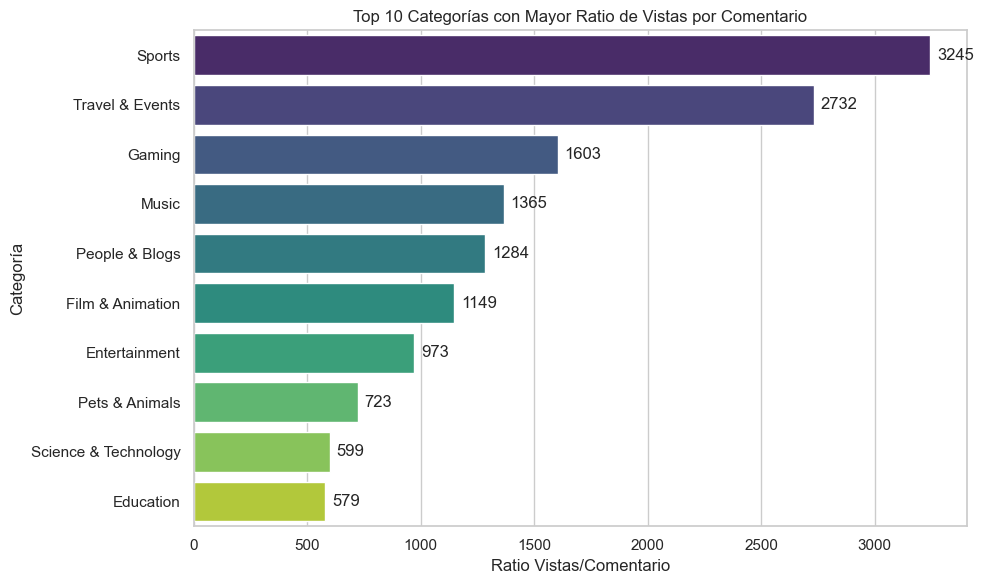

In [29]:
# Calcular ratio
data_limpia = data_limpia[data_limpia['comment_count'] > 0]
data_limpia['views_per_comment'] = data_limpia['views'] / data_limpia['comment_count']

# Agrupar por categoría
top_categorias = data_limpia.groupby('category_name')['views_per_comment'].mean().dropna().sort_values(ascending=False).head(10)

# Graficar con etiquetas
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_categorias.values, y=top_categorias.index, palette="viridis")
plt.title("Top 10 Categorías con Mayor Ratio de Vistas por Comentario")
plt.xlabel("Ratio Vistas/Comentario")
plt.ylabel("Categoría")

# Añadir etiquetas numéricas
for i, valor in enumerate(top_categorias.values):
    ax.text(valor + 30, i, f"{valor:.0f}", va='center')

plt.tight_layout()
plt.show()


### Conclusión:

El análisis muestra que las categorías **"Sports"** y **"Travel & Events"** presentan el ratio más alto de vistas por comentario, lo que indica un gran alcance y visualización con relativamente baja participación en comentarios.  
Por otro lado, categorías como **"Education"** o **"Science & Technology"** tienen ratios más bajos, lo que sugiere una audiencia más participativa en comentarios en proporción al número de vistas.

---

### Recomendación para el negocio:

- Si el objetivo es **maximizar el alcance y visibilidad**, se recomienda enfocar la producción de contenido en categorías como **"Sports"** y **"Travel & Events"**, ya que permiten llegar a más personas por cada comentario recibido.

- Si la prioridad es **generar conversación o engagement profundo**, se sugiere apostar por categorías como **"Education"** o **"Science & Technology"**, donde los usuarios tienden a interactuar más activamente.

- Se recomienda además realizar pruebas A/B para comparar el rendimiento en función de los objetivos clave del negocio (branding, tráfico, conversiones, etc.).


5. ¿Cómo ha cambiado el volumen de los videos en tendencia a lo largo del tiempo?

C:\Users\Usuario\AppData\Local\Temp\ipykernel_31372\3322915393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_limpia['trending_date'] = pd.to_datetime(data_limpia['trending_date'], format='%y.%d.%m', errors='coerce')


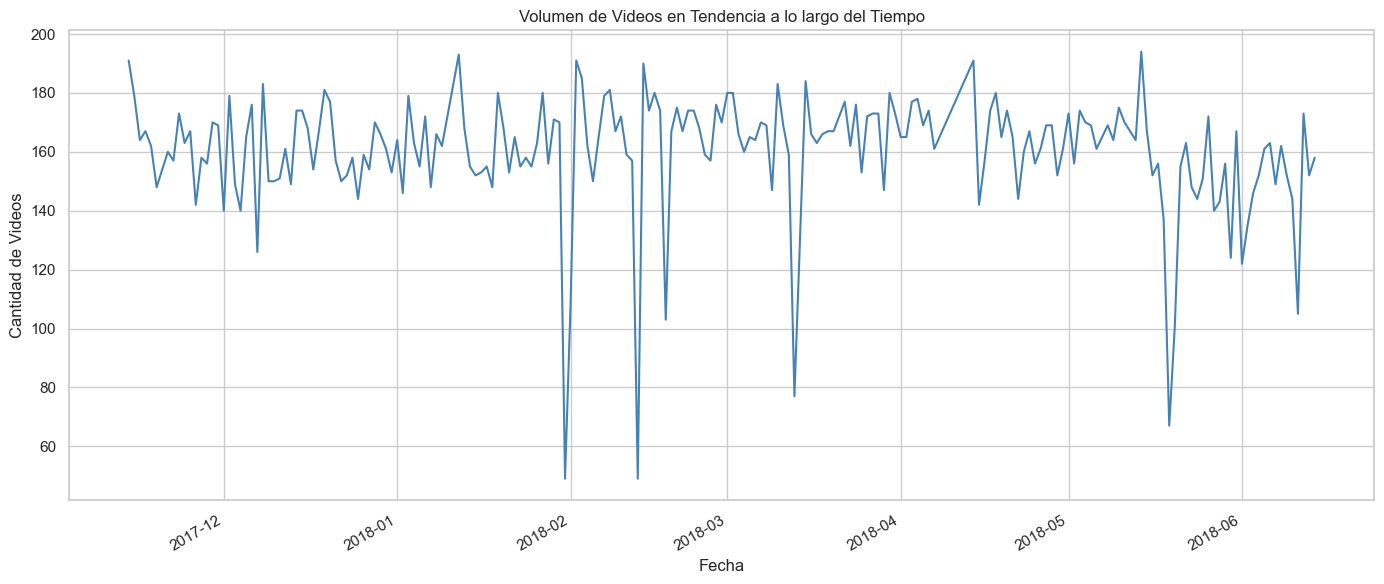

In [25]:
# Convertir trending_date si no se hizo antes
data_limpia['trending_date'] = pd.to_datetime(data_limpia['trending_date'], format='%y.%d.%m', errors='coerce')

# Agrupar y graficar
volumen_tiempo = data_limpia.groupby('trending_date').size()

plt.figure(figsize=(14, 6))
volumen_tiempo.plot(kind='line', color='steelblue')
plt.title("Volumen de Videos en Tendencia a lo largo del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Videos")
plt.tight_layout()
plt.show()


### Conclusión:

El análisis del volumen de videos en tendencia muestra que, en general, **se mantiene una alta constancia diaria** de publicaciones, con un promedio de entre **140 y 180 videos por día**.  
Sin embargo, se observan **caídas bruscas** en la cantidad de videos en ciertas fechas, principalmente en los meses de:

- **Febrero 2018**  
- **Marzo 2018**  
- **Mayo y junio 2018**

Estas caídas pueden deberse a **problemas de recolección de datos, cambios en el algoritmo de tendencias de YouTube** o incluso a **eventos particulares como feriados o actualizaciones del sistema**.

---

### Recomendación para el negocio:

- Evitar realizar comparaciones directas de métricas en días donde el volumen total de videos fue **anormalmente bajo**, ya que podrían distorsionar los análisis.

- Para lograr mayor visibilidad, se sugiere **lanzar contenido en los días de mayor actividad (alta cantidad de videos en tendencia)**, ya que estos reflejan **una mayor audiencia activa**.

- Sería beneficioso para la empresa implementar una rutina de análisis que **detecte anomalías temporales** y las marque, para **excluirlas de modelos predictivos o de comportamiento**.


6. ¿Qué Canales de YouTube son tendencia más frecuentemente? ¿Y cuáles con menos
frecuencia?

C:\Users\Usuario\AppData\Local\Temp\ipykernel_31372\1201276803.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_canales.values, y=top_canales.index, palette="magma")


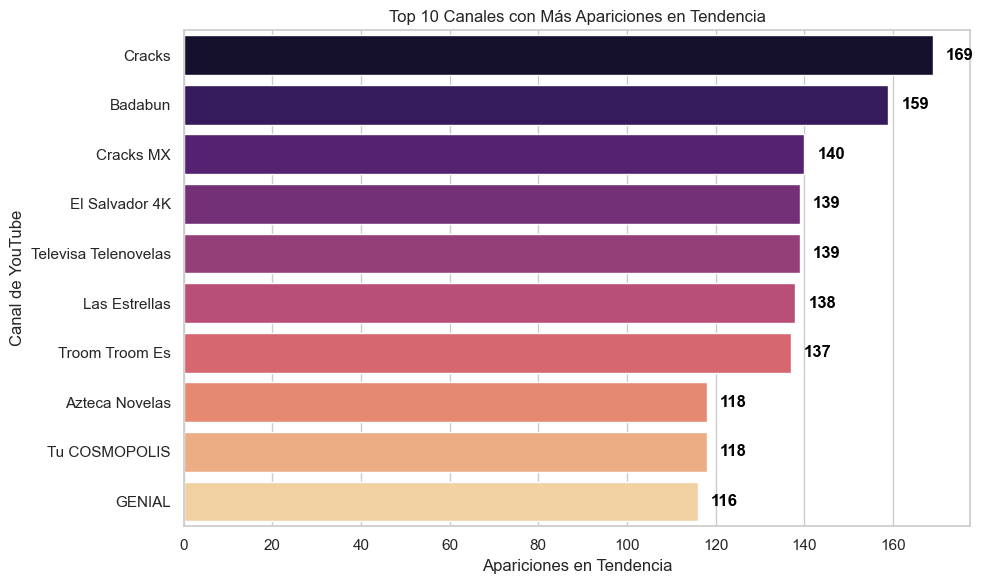

In [30]:
# Top 10 canales con más apariciones
top_canales = data_limpia['channel_title'].value_counts().head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_canales.values, y=top_canales.index, palette="magma")
plt.title("Top 10 Canales con Más Apariciones en Tendencia")
plt.xlabel("Apariciones en Tendencia")
plt.ylabel("Canal de YouTube")

# Mostrar los valores al costado de cada barra
for i, value in enumerate(top_canales.values):
    ax.text(value + 3, i, str(value), va='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_31372\807480715.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='apariciones', y='channel_title', data=df_canales_muestra, palette='cubehelix')


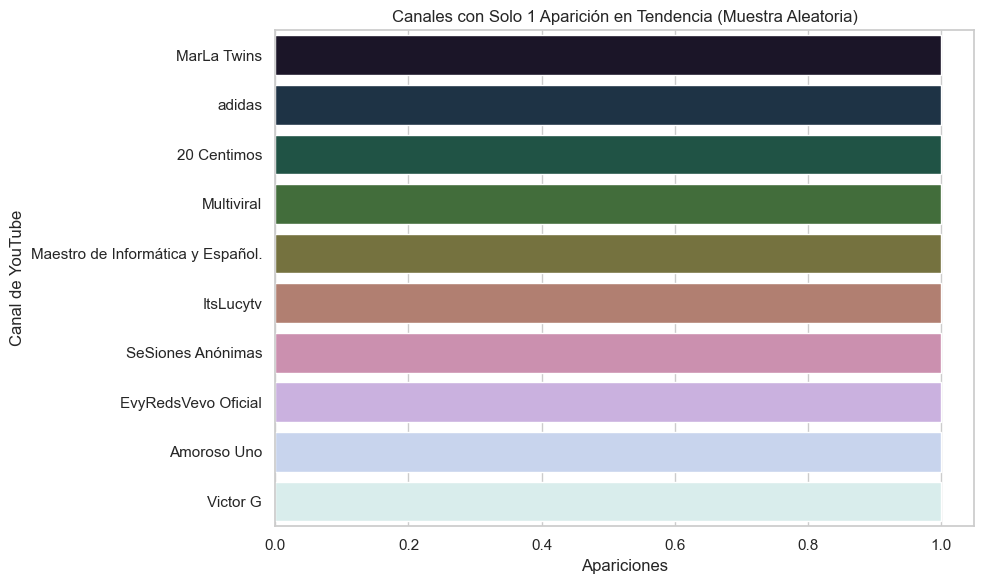

In [32]:
# Canales con solo 1 aparición
canales_frecuencia = data_limpia['channel_title'].value_counts()
canales_una_aparicion = canales_frecuencia[canales_frecuencia == 1]

# Tomar muestra de 10 (puedes cambiar el número)
canales_muestra = canales_una_aparicion.sample(10, random_state=42)

# Convertir a DataFrame para graficar
df_canales_muestra = canales_muestra.reset_index()
df_canales_muestra.columns = ['channel_title', 'apariciones']

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='apariciones', y='channel_title', data=df_canales_muestra, palette='cubehelix')
plt.title("Canales con Solo 1 Aparición en Tendencia (Muestra Aleatoria)")
plt.xlabel("Apariciones")
plt.ylabel("Canal de YouTube")
plt.tight_layout()
plt.show()


### Análisis de Apariciones en Tendencia por Canal

#### Conclusión
El gráfico de los **Top 10 canales** revela que ciertos creadores, como **Cracks**, **Badabun** y **Cracks MX**, dominaron las tendencias con más de 140 apariciones cada uno. Esto sugiere una fuerte presencia en la plataforma y un contenido recurrentemente popular o viral. En contraste, el segundo gráfico muestra una muestra de canales con **solo una aparición** en tendencia, lo cual refleja una gran dispersión en el ecosistema de creadores, donde muchos apenas logran alcanzar visibilidad.

#### Recomendación al negocio
Se recomienda a la empresa cliente analizar los patrones de contenido, horarios de publicación y temáticas de los canales con más apariciones para **identificar factores de éxito replicables**. Además, sería valioso diseñar estrategias de colaboración con canales emergentes (de baja aparición) que tengan potencial, con el fin de diversificar el contenido y captar nuevas audiencias.
